In [1]:
import os 
import sys
sys.path.append('/home/mingxuan.zhang/scGraphLLM/scGraphLLM')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from GNN_modules import *
from MLP_modules import *
import lightning.pytorch as pl
from _globals import * ## these define the indices for the special tokens 
from torch_geometric.utils import negative_sampling
from models import GDTransformer

/hpc/mydata/mingxuan.zhang/anaconda/23.1.0-3/x86_64/envs/scllm_2/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /hpc/mydata/mingxuan.zhang/anaconda/23.1.0-3/x86_64/envs/scllm_2/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [3]:
from config import *

In [4]:
torch.cuda.is_available()

True

In [5]:
vanilla_path = "/hpc/mydata/mingxuan.zhang/GLM/model_out/vanilla_manitou_masked:2025-01-25@22:33:41/checkpoints/epoch=1-step=5000.ckpt"

In [6]:
vanilla_model = GDTransformer.load_from_checkpoint(vanilla_path, config=vanilla_manitou)

In [7]:
gdk_path = "/hpc/mydata/mingxuan.zhang/GLM/model_out/GLM_manitou_masked:2025-01-25@22:33:42/checkpoints/epoch=1-step=5000.ckpt"

In [8]:
gdk_model = GDTransformer.load_from_checkpoint(gdk_path, config=graph_kernel_attn_manitou)

In [9]:
#gdk_model_state_dict = torch.load(gdk_path)["state_dict"]
#gdk_model_state_dict.keys()

In [10]:
#gdk_model = GDTransformer(config=graph_kernel_attn_manitou)
#cpt = torch.load(gdk_path)
#filtered_state_dict = {k: v for k, v in cpt["state_dict"].items() if ("transformer_encoder.wqkv.Wp.weight" not in k) & ("transformer_encoder.wqkv.Wp.bias" not in k)}

In [11]:
#filtered_state_dict.keys()

In [12]:
#gdk_model.load_state_dict(filtered_state_dict, strict=False)

In [13]:
from data import *
from torch.nn.utils.rnn import pad_sequence

In [14]:
def collate_fn(batch):
    data = { "orig_gene_id" : [], "orig_rank_indices" : [], "gene_mask" : [], 
            "rank_mask" : [], "both_mask" : [], "edge_index": [], "num_nodes" :[], 
            "spectral_pe" : [], "dataset_name" : [] }
    
    # Make a dictionary of lists from the list of dictionaries
    for b in batch:
        for key in data.keys():
            data[key].append(b[key])

    # Pad these dictionaries of lists
    for key in data.keys():
        if (key != "dataset_name") & (key != "edge_index") & (key != "num_nodes"):
            data[key] = pad_sequence(data[key], batch_first=True).squeeze()

    return data

In [15]:
transformer_data_module = GraphTransformerDataModule(graph_kernel_attn_1024.data_config, collate_fn=collate_fn)
train_transformer_dl = transformer_data_module.train_dataloader()
val_transformer_dl = transformer_data_module.val_dataloader()

/hpc/projects/group.califano/GLM/data/cxg_cache_1024/train
/hpc/projects/group.califano/GLM/data/cxg_cache_1024/valSG
/hpc/projects/group.califano/GLM/data/cxg_cache_1024/valHOG


In [16]:
val_hog_data = val_transformer_dl[-1]
val_sg_data = val_transformer_dl[0]

In [17]:
import pandas as pd

In [18]:
ensg_to_hugo = pd.read_csv("gene-name-map.csv").rename(columns={"Unnamed: 0": "gene_id", "ensg.values":"ens"})
ensg_to_hugo.head()

,gene_id,enst.values,ens,entrez.values,hugo.values,biotype.values
0,6,ENST00000361390,ENSG00000198888,g_4535_,MT-ND1,protein_coding
1,10,ENST00000361453,ENSG00000198763,g_4536_,MT-ND2,protein_coding
2,16,ENST00000361624,ENSG00000198804,g_4512_,MT-CO1,protein_coding
3,19,ENST00000361739,ENSG00000198712,g_4513_,MT-CO2,protein_coding
4,21,ENST00000361851,ENSG00000228253,g_4509_,MT-ATP8,protein_coding


In [19]:
id_to_gene = pd.read_csv("cellxgene_map.csv").rename(columns={"gene_name":"ens"})
id_to_gene

,ens,idx
0,<PAD>,0
1,<MASK>,1
2,ENSG00000000003,2
3,ENSG00000000005,3
4,ENSG00000000419,4
...,...,...
19241,ENSG00000288701,19241
19242,ENSG00000288702,19242
19243,ENSG00000288705,19243
19244,ENSG00000288709,19244


In [20]:
id_to_gene = id_to_gene.iloc[2:]
id_to_gene

,ens,idx
2,ENSG00000000003,2
3,ENSG00000000005,3
4,ENSG00000000419,4
5,ENSG00000000457,5
6,ENSG00000000460,6
...,...,...
19241,ENSG00000288701,19241
19242,ENSG00000288702,19242
19243,ENSG00000288705,19243
19244,ENSG00000288709,19244


In [21]:
merged_df = id_to_gene.merge(ensg_to_hugo, on='ens')[['idx', 'hugo.values']].drop_duplicates()
merged_df

,idx,hugo.values
0,2,TSPAN6
5,3,TNMD
7,4,DPM1
23,5,SCYL3
28,6,C1orf112
...,...,...
161707,19241,PRRC2B
161717,19242,UGT1A3
161718,19243,UGT1A5
161719,19244,F8A2


In [22]:
from MLP_modules import LinkPredictHead
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import tqdm
import matplotlib.pyplot as plt
import random

In [23]:
def random_edge_mask(edge_index, mask_ratio=0.15):
    device = edge_index.device
    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()
    E = edge_index.size(1)
    
    pairs = {}
    for i in range(E):
        u, v = src[i], dst[i]
        mn, mx = (u, v) if u <= v else (v, u)
        if (mn, mx) not in pairs:
            pairs[(mn, mx)] = []
        pairs[(mn, mx)].append(i)
    
    unique_pairs = list(pairs.keys())  
    num_unique = len(unique_pairs)
    num_mask = int(mask_ratio * num_unique)
    
    perm = torch.randperm(num_unique, device=device)
    masked_pairs = [unique_pairs[i.item()] for i in perm[:num_mask]]
    masked_indices = []
    for pair in masked_pairs:
        masked_indices.extend(pairs[pair]) 
    masked_indices = torch.tensor(masked_indices, device=device, dtype=torch.long)
    
    masked_edge_index = edge_index[:, masked_indices]

    return masked_edge_index

In [24]:
def link_pred_loss(predictor, node_embedding, mask_locs, edge_index_list):
    pos_out = []
    neg_out = []
    pos_labels = []
    neg_labels = []

    batch_size, num_nodes, embed_dim = node_embedding.shape
    device = node_embedding.device

    for batch in range(batch_size):
        masked_nodes = torch.where(mask_locs[batch])[0]
        if masked_nodes.numel() == 0:
            continue
        masked_nodes = masked_nodes.to(device)
        edge_index = edge_index_list[batch].to(device)
        masked_nodes_bool = torch.zeros(num_nodes, dtype=torch.bool, device=device)
        masked_nodes_bool[masked_nodes] = True
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        edge_mask = (~masked_nodes_bool[src_nodes]) & (~masked_nodes_bool[dst_nodes])
        pos_edge_index = edge_index[:, edge_mask]
        if pos_edge_index.size(1) == 0:
            continue

        num_neg_samples = pos_edge_index.size(1)
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=num_nodes,
            num_neg_samples=num_neg_samples,
            method='sparse'
        ).to(device)

        # Positive scores
        src_emb_pos = node_embedding[batch, pos_edge_index[0]]
        dst_emb_pos = node_embedding[batch, pos_edge_index[1]]
        pos_scores = predictor(src_emb_pos, dst_emb_pos)
        pos_out.append(pos_scores)
        pos_labels.append(torch.ones_like(pos_scores, device=device))  # Positive labels (1)

        # Negative scores
        src_emb_neg = node_embedding[batch, neg_edge_index[0]]
        dst_emb_neg = node_embedding[batch, neg_edge_index[1]]
        neg_scores = predictor(src_emb_neg, dst_emb_neg)
        neg_out.append(neg_scores)
        neg_labels.append(torch.zeros_like(neg_scores, device=device))  # Negative labels (0)

    if pos_out:
        pos_out = torch.cat(pos_out, dim=0)
        neg_out = torch.cat(neg_out, dim=0)
        pos_labels = torch.cat(pos_labels, dim=0)
        neg_labels = torch.cat(neg_labels, dim=0)

        # Loss calculation
        pos_loss = -torch.log(pos_out + 1e-10).mean()
        neg_loss = -torch.log(1 - neg_out + 1e-10).mean()

        # Concatenate outputs and labels
        all_outputs = torch.cat([pos_out, neg_out], dim=0)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)

        return pos_loss + neg_loss, all_outputs, all_labels
    else:
        return torch.tensor(0.0, device=device), torch.tensor([], device=device), torch.tensor([], device=device)

In [25]:
def MGM_loss(
    predictor,
    node_embedding,
    full_graphs,
    masked_graphs,
    device='cuda'
):
    batch_size, num_nodes, _ = node_embedding.shape
    assert torch.any(torch.isnan(node_embedding)) == False, "node embedding has nan, check graph structure"
    pos_preds = []
    neg_preds = []
    pos_labels = []
    neg_labels = []

    for b_idx in range(batch_size):
        masked_edges = masked_graphs[b_idx].to(device)
        if masked_edges.size(1) == 0:
            continue  # no edges to predict, skip

        emb = node_embedding[b_idx]
        #print(torch.any(torch.isnan(emb)))
        full_edge_index = full_graphs[b_idx].to(device)

        neg_edge_index = negative_sampling(
            edge_index=full_edge_index,
            num_nodes=num_nodes,
            num_neg_samples=masked_edges.size(1),
            method='sparse'
        ).to(device)

        # Positive scores (for masked edges)
        src_emb_pos = emb[masked_edges[0]]
        dst_emb_pos = emb[masked_edges[1]]
        pos_scores = predictor(src_emb_pos, dst_emb_pos)  
        pos_preds.append(pos_scores)
        pos_labels.append(torch.ones_like(pos_scores))

        # Negative scores
        src_emb_neg = emb[neg_edge_index[0]]
        dst_emb_neg = emb[neg_edge_index[1]]
        neg_scores = predictor(src_emb_neg, dst_emb_neg)
        neg_preds.append(neg_scores)
        neg_labels.append(torch.zeros_like(neg_scores))

    if not pos_preds:
        return (
            torch.tensor(0.0, device=device),
            torch.tensor([], device=device),
            torch.tensor([], device=device),
        )

    # Concatenate
    pos_preds = torch.cat(pos_preds, dim=0)
    neg_preds = torch.cat(neg_preds, dim=0)
    pos_labels = torch.cat(pos_labels, dim=0)
    neg_labels = torch.cat(neg_labels, dim=0)

    pos_loss = F.binary_cross_entropy(pos_preds, pos_labels)
    neg_loss = F.binary_cross_entropy(neg_preds, neg_labels)
    loss = pos_loss + neg_loss

    # Concatenate all outputs/labels for metrics
    all_outputs = torch.cat([pos_preds, neg_preds], dim=0)
    all_labels = torch.cat([pos_labels, neg_labels], dim=0)

    return loss, all_outputs, all_labels

In [26]:
def send_to_gpu(data):
    if isinstance(data, torch.Tensor):
        return data.to('cuda')  # Send tensor to GPU
    elif isinstance(data, list):
        return [send_to_gpu(item) for item in data]  # Recursively process lists
    elif isinstance(data, dict):
        return {key: send_to_gpu(value) for key, value in data.items()}  # Recursively process dicts
    else:
        return data  # If not a tensor or list/dict, leave unchanged

In [27]:
def train_step(pretrained_model, ft_model, batch, opt, task = 'link_pred'):
    pretrained_model.eval()
    ft_model.train()
    batch = send_to_gpu(batch)
    if task == 'link_pred':
        embedding, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrained_model(batch)
        L_g, _, _ = link_pred_loss(ft_model, embedding, mask_locs[0], edge_index_list)
    elif task == 'masked_edge_pred':
        m_graphs = []
        full_graphs = batch['edge_index']
        for edge_index in full_graphs:
            m_graph = random_edge_mask(edge_index)
            m_graphs.append(m_graph)
        batch['edge_index'] = m_graphs
        embedding, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrained_model(batch)
        L_g, _, _ = MGM_loss(ft_model, embedding, full_graphs, m_graphs)
    else:
        raise ValueError(f"Task {task} not supported")
    opt.zero_grad()
    L_g.backward()
    opt.step()
    return L_g

def transfer_learning(train_dataloader, pretrained_model, ft_model, 
                      lr=1e-3, num_epochs=100, max_num_batches=200, task='link_pred'):
    train_losses = []
    opt = torch.optim.Adam(ft_model.parameters(), lr=lr, weight_decay=1e-4)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        train_loss_epoch = 0
        train_batches = len(train_dataloader)
        num_batches = 0
        for batch in  tqdm.tqdm(train_dataloader, desc="Training", leave=False):
            train_loss = train_step(pretrained_model, ft_model, batch, opt, task=task)
            train_loss_epoch += train_loss.item()
            num_batches += 1
            if num_batches >= max_num_batches:
                break
        train_loss_epoch /= train_batches
        train_losses.append(train_loss_epoch)
        print(f"Train loss: {train_loss_epoch:.4f}")
    return train_losses
    
def predict_and_compare(test_dataloader, pretrain1, pretrain2, model1, model2, max_num_batches=100):
    model1.eval().to("cuda")
    model2.eval().to("cuda")
    pretrain1.eval().to("cuda")
    pretrain2.eval().to("cuda")
    
    all_preds1 = []
    all_preds2 = []
    all_labels = []
    n_b = 0
    for batch in tqdm.tqdm(test_dataloader, leave=False):
        batch = send_to_gpu(batch)
        embedding1, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrain1(batch)
        embedding2, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = pretrain2(batch)
        
        L_g1, preds1, labels = link_pred_loss(model1, embedding1, mask_locs[0], edge_index_list)
        L_g2, preds2, labels = link_pred_loss(model2, embedding2, mask_locs[0], edge_index_list)
        
        all_preds1.extend(preds1.cpu().detach().numpy())
        all_preds2.extend(preds2.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
        
        n_b += 1
        if n_b >= max_num_batches:
            break
    
    # AUROC
    fpr1, tpr1, _ = roc_curve(all_labels, all_preds1)
    fpr2, tpr2, _ = roc_curve(all_labels, all_preds2)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)
    
    # PR
    p1, r1, _ = precision_recall_curve(all_labels, all_preds1)
    p2, r2, _ = precision_recall_curve(all_labels, all_preds2)
    apr1 = average_precision_score(all_labels, all_preds1)
    apr2 = average_precision_score(all_labels, all_preds2)
    
    return fpr1, tpr1, auc1, fpr2, tpr2, auc2, p1, r1, apr1, p2, r2, apr2

In [28]:
def auroc_curves(fpr1, tpr1, auc1, fpr2, tpr2, auc2):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, label=f"fine-tune w. vanilla embedding (AUC = {auc1:.3f})")
    plt.plot(fpr2, tpr2, label=f"fine-tune w. GraphDKA embedding (AUC = {auc2:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Transfer learning AUROC")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [29]:
def pr_curves(precision1, recall1, ap1, precision2, recall2, ap2):
    plt.figure(figsize=(8, 6))

    # Plot the first PR curve
    plt.plot(recall1, precision1, label=f"fine-tune w. vanilla embedding (Avg. Prec. = {ap1:.3f})", linestyle='-', marker=None)

    # Plot the second PR curve
    plt.plot(recall2, precision2, label=f"fine-tune w. GraphDKA embedding (Avg. Prec. = {ap2:.3f})", linestyle='--', marker=None)

    # Add labels and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Transfer learning Precision-Recall Curve")
    plt.legend(loc="best")
    plt.grid()

    # Set axis limits for better visualization
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Show the plot
    plt.show()

In [30]:
def random_sample_batches(dataloader, n):
    # Convert the dataloader to a list of batches
    batches = list(dataloader)
    # Randomly sample n batches
    sampled_batches = random.sample(batches, n)
    return sampled_batches

# Compare with Vanilla Transformer - Link Pred

In [31]:
vanilla_lp = LinkPredictHead(256, 1).to("cuda")
gdk_lp = LinkPredictHead(256, 1).to("cuda")

In [ ]:
vanilla_loss = transfer_learning(val_sg_data, pretrained_model=vanilla_model, ft_model=vanilla_lp, 
                                 num_epochs=1, max_num_batches=100, task='link_pred')

In [29]:
gdk_loss = transfer_learning(val_sg_data, pretrained_model=gdk_model, ft_model=gdk_lp, 
                             num_epochs=1, max_num_batches=100, task='link_pred')

Epoch 1/1
556923
556923


Training:   0%|                                                                                                         | 0/34808 [00:00<?, ?it/s]

556923


Train loss: 0.0010


In [30]:
torch.save(vanilla_lp.state_dict(), "vanilla_lp.pth")
torch.save(gdk_lp.state_dict(), "gdk_lp.pth")

In [31]:
vanilla_lp.load_state_dict(torch.load("vanilla_lp.pth"))
gdk_lp.load_state_dict(torch.load("gdk_lp.pth"))
fpr1, tpr1, auc1, fpr2, tpr2, auc2, p1, r1, apr1, p2, r2, apr2 = predict_and_compare(val_hog_data, 
                                                                                     vanilla_model, 
                                                                                     gdk_model, 
                                                                                     vanilla_lp, 
                                                                                     gdk_lp, max_num_batches=30)

/tmp/ipykernel_67180/1730105873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vanilla_lp.load_state_dict(torch.load("vanilla_lp.pth"))
/tmp/ipykernel_67180/1730105873.

521714


  0%|                                                                                                                   | 0/32608 [00:00<?, ?it/s]

521714


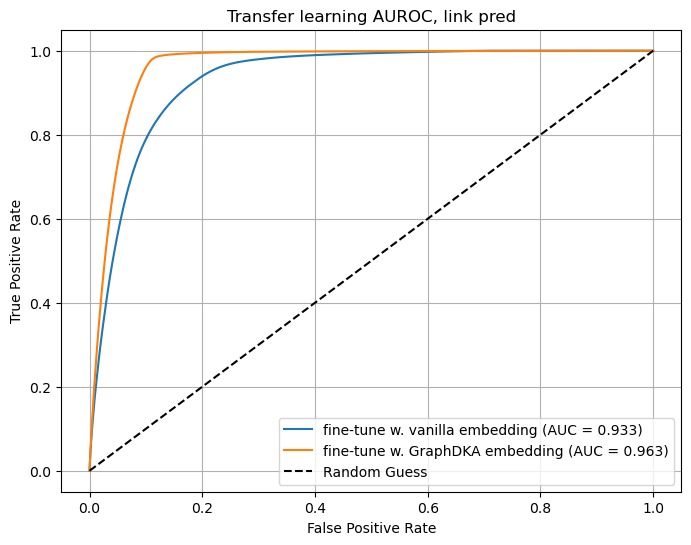

In [32]:
auroc_curves(fpr1, tpr1, auc1, fpr2, tpr2, auc2)

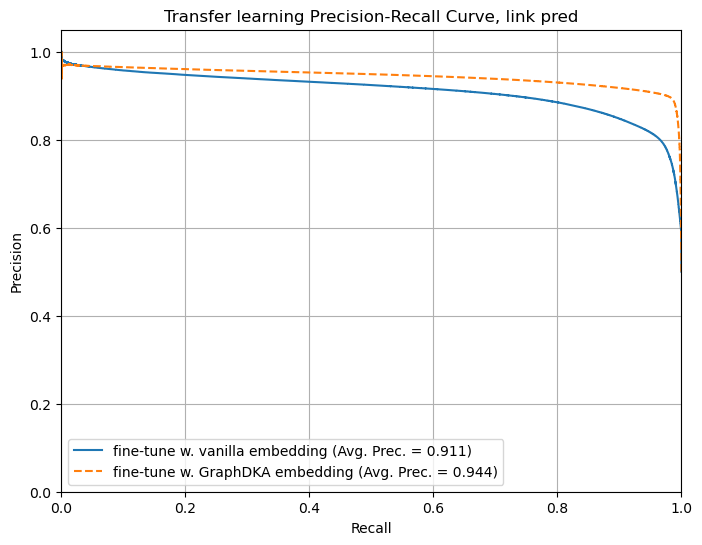

In [33]:
pr_curves(p1, r1, apr1, p2, r2, apr2)

# Compare with Vanilla Transformer - Masked graph modeling

In [32]:
from torch.nn.utils.rnn import pad_sequence

In [33]:
import tqdm

In [34]:
def get_embedding(dataloader, model, max_num_batches=100):
    model.eval().to("cuda")
    embeddings = []
    gene_ids = []
    n_b = 0
    for batch in tqdm.tqdm(dataloader, leave=False):
        batch = send_to_gpu(batch)
        curr_dim = batch['orig_gene_id'].shape[-1]
        if curr_dim < 5000:
            continue
        embedding, target_gene_ids, target_rank_ids, mask_locs, edge_index_list, num_nodes_list = model(batch)
        embeddings.append(embedding.cpu())
        gene_ids.append(target_gene_ids.cpu())
        n_b += 1
        if n_b >= max_num_batches:
            break
    embeddings = torch.cat(embeddings, dim=0)
    gene_ids = torch.cat(gene_ids, dim=0)
    return embeddings, gene_ids

In [35]:
def predict_and_compare_MGM(test_dataloader, pretrain1, pretrain2, model1, model2, max_num_batches=100):
    model1.eval().to("cuda")
    model2.eval().to("cuda")
    pretrain1.eval().to("cuda")
    pretrain2.eval().to("cuda")
    
    all_preds1 = []
    all_preds2 = []
    all_labels = []

    n_b = 0
    for batch in tqdm.tqdm(test_dataloader, leave=False):
        batch = send_to_gpu(batch)
        full_graphs = batch['edge_index']
        m_graphs = []
        for edge_index in full_graphs:
            m_graph = random_edge_mask(edge_index)
            m_graphs.append(m_graph)
        
        batch['edge_index'] = m_graphs
        embedding1, target_gene_ids, target_rank_ids, mask_locs, _, num_nodes_list = pretrain1(batch)
        embedding2, target_gene_ids, target_rank_ids, mask_locs, _, num_nodes_list = pretrain2(batch)
        
        L_g1, preds1, labels = MGM_loss(model1, embedding1, full_graphs, m_graphs)
        L_g2, preds2, labels = MGM_loss(model2, embedding2, full_graphs, m_graphs)
        
        all_preds1.extend(preds1.cpu().detach().numpy())
        all_preds2.extend(preds2.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
        
        n_b += 1
        if n_b >= max_num_batches:
            break
    
    # AUROC
    fpr1, tpr1, _ = roc_curve(all_labels, all_preds1)
    fpr2, tpr2, _ = roc_curve(all_labels, all_preds2)
    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)
    
    # PR
    p1, r1, _ = precision_recall_curve(all_labels, all_preds1)
    p2, r2, _ = precision_recall_curve(all_labels, all_preds2)
    apr1 = average_precision_score(all_labels, all_preds1)
    apr2 = average_precision_score(all_labels, all_preds2)
    
    return fpr1, tpr1, auc1, fpr2, tpr2, auc2, p1, r1, apr1, p2, r2, apr2

In [36]:
vanilla_lp = LinkPredictHead(256, 1).to("cuda")
gdk_lp = LinkPredictHead(256, 1).to("cuda")

In [37]:
vanilla_loss = transfer_learning(val_sg_data, pretrained_model=vanilla_model, ft_model=vanilla_lp, 
                                 num_epochs=1, max_num_batches=100, task='masked_edge_pred')

Epoch 1/1
542773
542773


Training:   0%|                                                                                                                          | 0/33924 [00:00<?, ?it/s]

542773


Train loss: 0.0017


In [38]:
gdk_loss = transfer_learning(val_sg_data, pretrained_model=gdk_model, ft_model=gdk_lp, 
                                 num_epochs=1, max_num_batches=100, task='masked_edge_pred')

Epoch 1/1
542773
542773


Training:   0%|                                                                                                                          | 0/33924 [00:00<?, ?it/s]

542773


Train loss: 0.0011


In [39]:
fpr1, tpr1, auc1, fpr2, tpr2, auc2, p1, r1, apr1, p2, r2, apr2 = predict_and_compare_MGM(val_hog_data, 
                                                                                     vanilla_model, 
                                                                                     gdk_model, 
                                                                                     vanilla_lp, 
                                                                                     gdk_lp, max_num_batches=50)

1002829


  0%|                                                                                                                                    | 0/62677 [00:00<?, ?it/s]

1002829


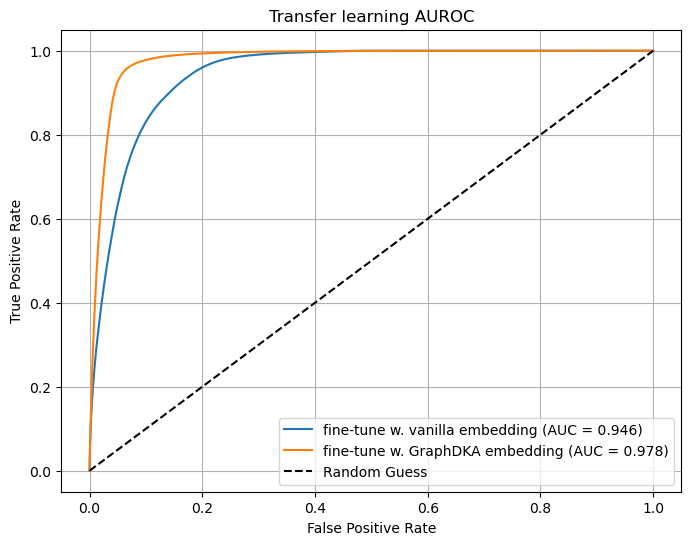

In [40]:
auroc_curves(fpr1, tpr1, auc1, fpr2, tpr2, auc2)

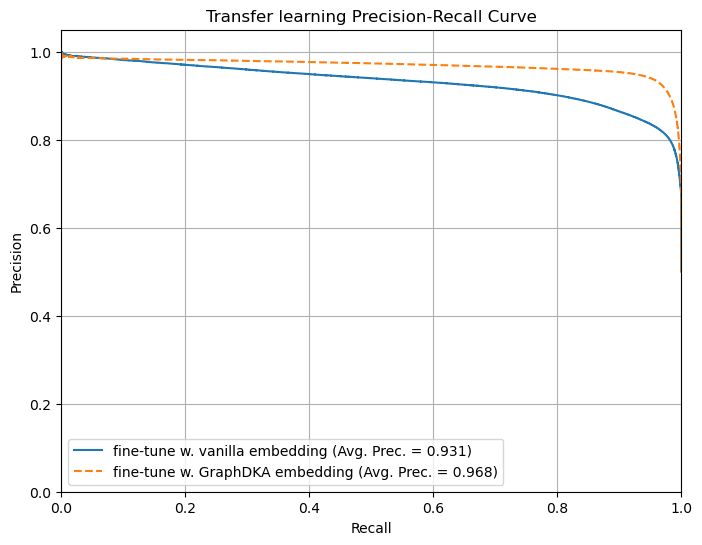

In [41]:
pr_curves(p1, r1, apr1, p2, r2, apr2)

In [28]:
gdk_embedding = get_embedding(val_hog_data, vanilla_model, max_num_batches=50)

1002829


  0%|                                                                                                                                    | 0/62677 [00:00<?, ?it/s]

1002829


In [29]:
gdk_emb, gene_ids = gdk_embedding
gene_ids.shape

torch.Size([480, 5012])

In [30]:
gdk_emb.shape

torch.Size([480, 5012, 256])

In [31]:
from _globals import *

In [32]:
def mean_pool_gene_embeddings(E: torch.Tensor, ID: torch.Tensor, max_gene_id: int = NUM_GENES - 2):
    ID_flat = ID.view(-1)
    E_flat = E.view(-1, E.size(-1))
    valid_mask = (ID_flat > 1)
    valid_ID = ID_flat[valid_mask]       
    valid_E  = E_flat[valid_mask, :]    
    if valid_ID.numel() == 0:
        return torch.empty(0), torch.empty(0)

    embedding_dim = E.size(-1)
    device = E.device
    gene_emb_sum = torch.zeros((max_gene_id + 1, embedding_dim),
                               dtype=E.dtype, device=device)
    gene_count   = torch.zeros((max_gene_id + 1,),
                               dtype=torch.long, device=device)

    gene_emb_sum.index_add_(0, valid_ID, valid_E)
    gene_count.index_add_(0, valid_ID, torch.ones_like(valid_ID, dtype=gene_count.dtype))

    nonzero_mask = (gene_count > 0)
    gene_emb_sum[nonzero_mask] /= gene_count[nonzero_mask].unsqueeze(1).float()

    return gene_emb_sum, gene_count

In [33]:
gdk_gene_emb, gdk_gene_count = mean_pool_gene_embeddings(gdk_emb, gene_ids)

In [34]:
gdk_gene_emb = gdk_gene_emb
gdk_gene_emb.shape

torch.Size([19246, 256])

In [35]:
important_gene_id = torch.where(gdk_gene_count > 10)[0]
important_gene_id.shape

torch.Size([10915])

In [36]:
gdk_gene_emb[important_gene_id].shape

torch.Size([10915, 256])

In [37]:
import umap

In [38]:
gdk_gene_emb_np = gdk_gene_emb[important_gene_id].cpu().detach().numpy()

In [39]:
from sklearn.preprocessing import StandardScaler

embeddings_scaled = StandardScaler().fit_transform(gdk_gene_emb_np)

In [40]:
gdk_gene_emb_2d = umap.UMAP(n_components=2).fit_transform(embeddings_scaled)

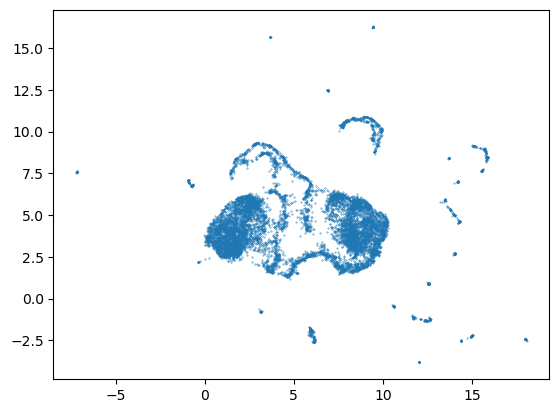

In [41]:
plt.scatter(gdk_gene_emb_2d[:, 0], gdk_gene_emb_2d[:, 1], s=0.1)

In [56]:
W = gdk_model.node_embedding.weight
W.shape

torch.Size([19502, 128])

In [57]:
W = W[important_gene_id].cpu().detach().numpy()
W.shape

(10923, 128)

In [58]:
embeddings_scaled = StandardScaler().fit_transform(W)

In [59]:
vnilla_gene_emb_2d = umap.UMAP(n_components=2).fit_transform(embeddings_scaled)

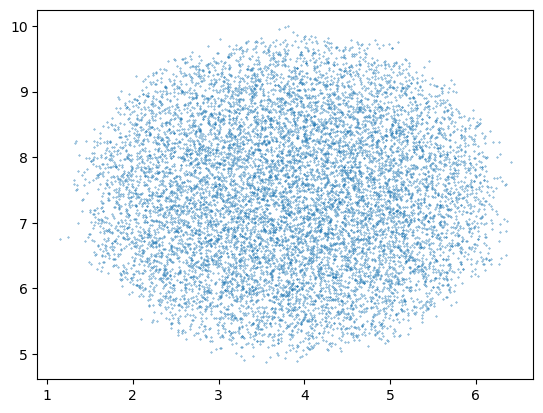

In [61]:
plt.scatter(vnilla_gene_emb_2d[:, 0], vnilla_gene_emb_2d[:, 1], s=0.1)

# Compare with scGPT

In [22]:
import scanpy as sc

In [28]:
adata = sc.read_h5ad("/home/mingxuan.zhang/fine-tune-data/immune_human.h5")
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [37]:
adata.obs['dat'].unique()

['Oetjen_A', 'Oetjen_P', 'Oetjen_U', 'Freytag', '10X', 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC', 'Villani']
Categories (10, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC', 'Villani']